<a href="https://colab.research.google.com/github/agustinivandinocco-python/pythonpracticateoria/blob/main/Colab/clase_7_charts_avanzados_pricing_TAMAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import urllib3
import numpy as np
from dateutil.relativedelta import relativedelta
from dateutil.relativedelta import relativedelta
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, Markdown, HTML
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Funciones

In [ ]:
def getDataV3(variableID):
    url = f"https://api.bcra.gob.ar/estadisticas/v3.0/Monetarias/{variableID}"
    r = requests.get(url, verify=False)
    return pd.DataFrame(r.json().get('results')).set_index('fecha')

events = {
    'TTM26': datetime(2026, 3, 16),
    'TTJ26': datetime(2026, 6, 30),
    'TTS26': datetime(2026, 9, 15),
    'TTD26': datetime(2026, 12, 15)
}

def simulate(TARGETs_TEM):
    TARGET_FECHA = pd.Timestamp("2026-12-31")
    tamar_tea = getDataV3(variableID=45)['valor'] / 100   # ID=45 es la TAMAR
    tamar_tea.index = pd.to_datetime(tamar_tea.index)
    tamar_tea = tamar_tea.sort_index()
    tamar_tea = tamar_tea.loc[tamar_tea.index > '2025-01-15']
    tamar_tem_spot = ((1 + tamar_tea)**(1/12) - 1)
    tamar_tem = tamar_tem_spot.to_frame(name='tamar_tem_spot')

    inicio = tamar_tem.index[-1] + timedelta(days=1)
    fechas_futuras = pd.date_range(inicio, TARGET_FECHA, freq='B')
    tem_actual = tamar_tem['tamar_tem_spot'].iloc[-1]
    dias_totales = (fechas_futuras[-1] - fechas_futuras[0]).days

    dfs_sim = []
    for TARGET_TEM in TARGETs_TEM:
        df_sim = tem_actual + (TARGET_TEM - tem_actual) * (fechas_futuras - fechas_futuras[0]).days / dias_totales
        df_sim = pd.DataFrame(data=df_sim, index=fechas_futuras, columns=[f'tamar_proy_{str(TARGET_TEM*100)}'])
        dfs_sim.append(df_sim)

    sims = pd.concat(dfs_sim, axis=1)
    df = pd.concat([tamar_tem, sims])
    df['TTM26'] = 0.0225
    df['TTJ26'] = 0.0219
    df['TTS26'] = 0.0217
    df['TTD26'] = 0.0214
    df["tamar_AVG"] = df["tamar_tem_spot"].expanding().mean().where(df["tamar_tem_spot"].notna())

    proy = ["tamar_proy_" + str(x*100) for x in TARGETs_TEM]
    for p in proy:
        df[f"{p}_AVG"] = (
            df["tamar_tem_spot"]
            .fillna(df[p])
            .expanding()
            .mean()
            .where(df[p].notna())
        )
    return df

def chart(df, title):
    plt.style.use('dark_background')
    fig, ax = plt.subplots(dpi=300, facecolor='black', figsize=(12,6))

    colores = {
        'tamar_tem_spot': 'white',
        'tamar_AVG': 'white',
        'TTM26': '#ff8888',
        'TTJ26': '#fb9f3f',
        'TTS26': '#4af6c3',
        'TTD26': '#66CCFF',
    }
    for x in TARGETs_TEM:
        colores.update({"tamar_proy_" + str(x*100) + "_AVG": 'silver'})

    for col, date in events.items():
        df.loc[df.index > date, col] = np.nan

    projection_cols = ["tamar_proy_" + str(x*100) + "_AVG" for x in TARGETs_TEM]
    fixed = ['TTM26','TTJ26','TTS26','TTD26']
    for col in colores:
        y = df[col].dropna()
        if y.empty: continue
        ls = ':' if col=='tamar_tem_spot' else '-'
        ax.plot(y.index, y.values, lw=0.75, color=colores[col], linestyle=ls)
        if col in fixed:
            x0, v0 = y.index[0], y.iloc[0]*100
            ax.text(x0, y.iloc[0]+0.00015, f"{col} tasa fija del {v0:.2f}%", fontsize=5, va='center', ha='left', color=colores[col])
        elif col in projection_cols:
            valor = col.split("_")[2]
            ax.text(y.index[-1], y.iloc[-1], f"escenario TAMAR {float(valor):.1f}% \nValor TEM a dic-26", fontsize=6, va='center', ha='left', color=colores[col])
        else:
            ax.text(y.index[-1], y.iloc[-1], col, fontsize=8, va='center', ha='left', color=colores[col])

    ymn, ymx = ax.get_ylim()
    ytop = ymn + 0.95 * (ymx - ymn)
    for label, xdate in events.items():
        ax.vlines(xdate, ymn, ytop, color=colores[label], lw=0.75, ls='--', label=label)
        ax.text(xdate, ytop, label, fontsize=7, va='bottom', ha='right', color=colores[label])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.2)
    ax.set_title(title, fontsize=8)
    ax.tick_params(axis='both', labelsize=6)
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.set_ylabel('Tasa Mensual', fontsize=7)
    labels_target = [f"con TAMAR {float(target*100):.1f}% => dic-26" for target in TARGETs_TEM]
    targets = list(events.keys())
    sobre_tasa_tamar = [[] for _ in targets]
    i = 0
    for label, date in events.items():
        tasa_fija = df[label].iloc[0]
        for target in TARGETs_TEM:
            pattern = f"tamar_proy_{target*100}"
            col = next(c for c in df.columns if c.startswith(pattern) and c.endswith("_AVG"))
            pos = df.index.get_indexer([date], method='bfill')[0]
            x, y = df.index[pos], df.iloc[pos][col]
            ax.scatter(x, y, s=140, color=colores[label], zorder=5, alpha=1)
            ax.text(x, y, f"{y*100:.2f}", color='black',
                    fontsize=5, ha='center', va='center', zorder=6)
            if y > tasa_fija:
                sobre_tasa_tamar[i].append(round(float(y - tasa_fija),6))
            else:
                sobre_tasa_tamar[i].append(0)
        i += 1
    plt.show()
    return sobre_tasa_tamar

def showTables(TARGETs_TEM, sobre_tasa_tamar, title_table):
    targets = list(events.keys())
    labels_target = [f"con TAMAR {float(target*100):.1f}% => dic-26" for target in TARGETs_TEM]
    hoy = pd.Timestamp.today()
    base = pd.Timestamp(2025, 1, 29)

    offset = (
        relativedelta(hoy, base).years * 12
        + relativedelta(hoy, base).months
        + relativedelta(hoy, base).days / 30
    )
    meses = pd.Series({
        k: (
            relativedelta(v, hoy).years * 12
            + relativedelta(v, hoy).months
            + relativedelta(v, hoy).days / 30
            + offset
        )
        for k, v in events.items()
    })


    sobre_tasa_tamar_tem = pd.DataFrame(sobre_tasa_tamar, columns=labels_target, index=targets).T.mul(100)
    r = sobre_tasa_tamar_tem.div(100)
    payoff = (((1 + r).pow(meses, axis=1) - 1) * 100).round(2)

    combined = pd.concat([sobre_tasa_tamar_tem, payoff], axis=1,
                        keys=['Diferencial TEM (Tamar-Fija)', 'Diferencial Payoff'])
    tem_cols    = [('Diferencial TEM (Tamar-Fija)', b)    for b in meses.index]
    payoff_cols = [('Diferencial Payoff', b) for b in meses.index]
    combined.loc['Meses de payoff', tem_cols]    = meses.values
    combined.loc['Meses de payoff', payoff_cols] = meses.values

    data_rows = combined.index.drop('Meses de payoff')
    color_map = {
        'TTM26':'#ff8888','TTJ26':'#fb9f3f',
        'TTS26':'#4af6c3','TTD26':'#66CCFF'
    }

    vmin, vmax = payoff.values.min(), payoff.values.max()

    styled = combined.style
    for bono, color in color_map.items():
        cmap = LinearSegmentedColormap.from_list(None, ['white', color])
        styled = styled.background_gradient(
            cmap=cmap,
            subset=pd.IndexSlice[data_rows, ('Diferencial TEM (Tamar-Fija)', bono)],
            axis=0
        )

    styled = styled.background_gradient(
        cmap='Greys_r',
        subset=pd.IndexSlice[data_rows, payoff_cols],
        axis=None,
        vmin=vmin,
        vmax=vmax
    ).format("{:.2f}%", subset=pd.IndexSlice[data_rows, :]) \
    .format("{:.2f}", subset=pd.IndexSlice[['Meses de payoff'], :])

    display(HTML('<br><br><h2>'+title_table+'</h2><br>'))
    display(styled)

# Simulacion Baja de tasas

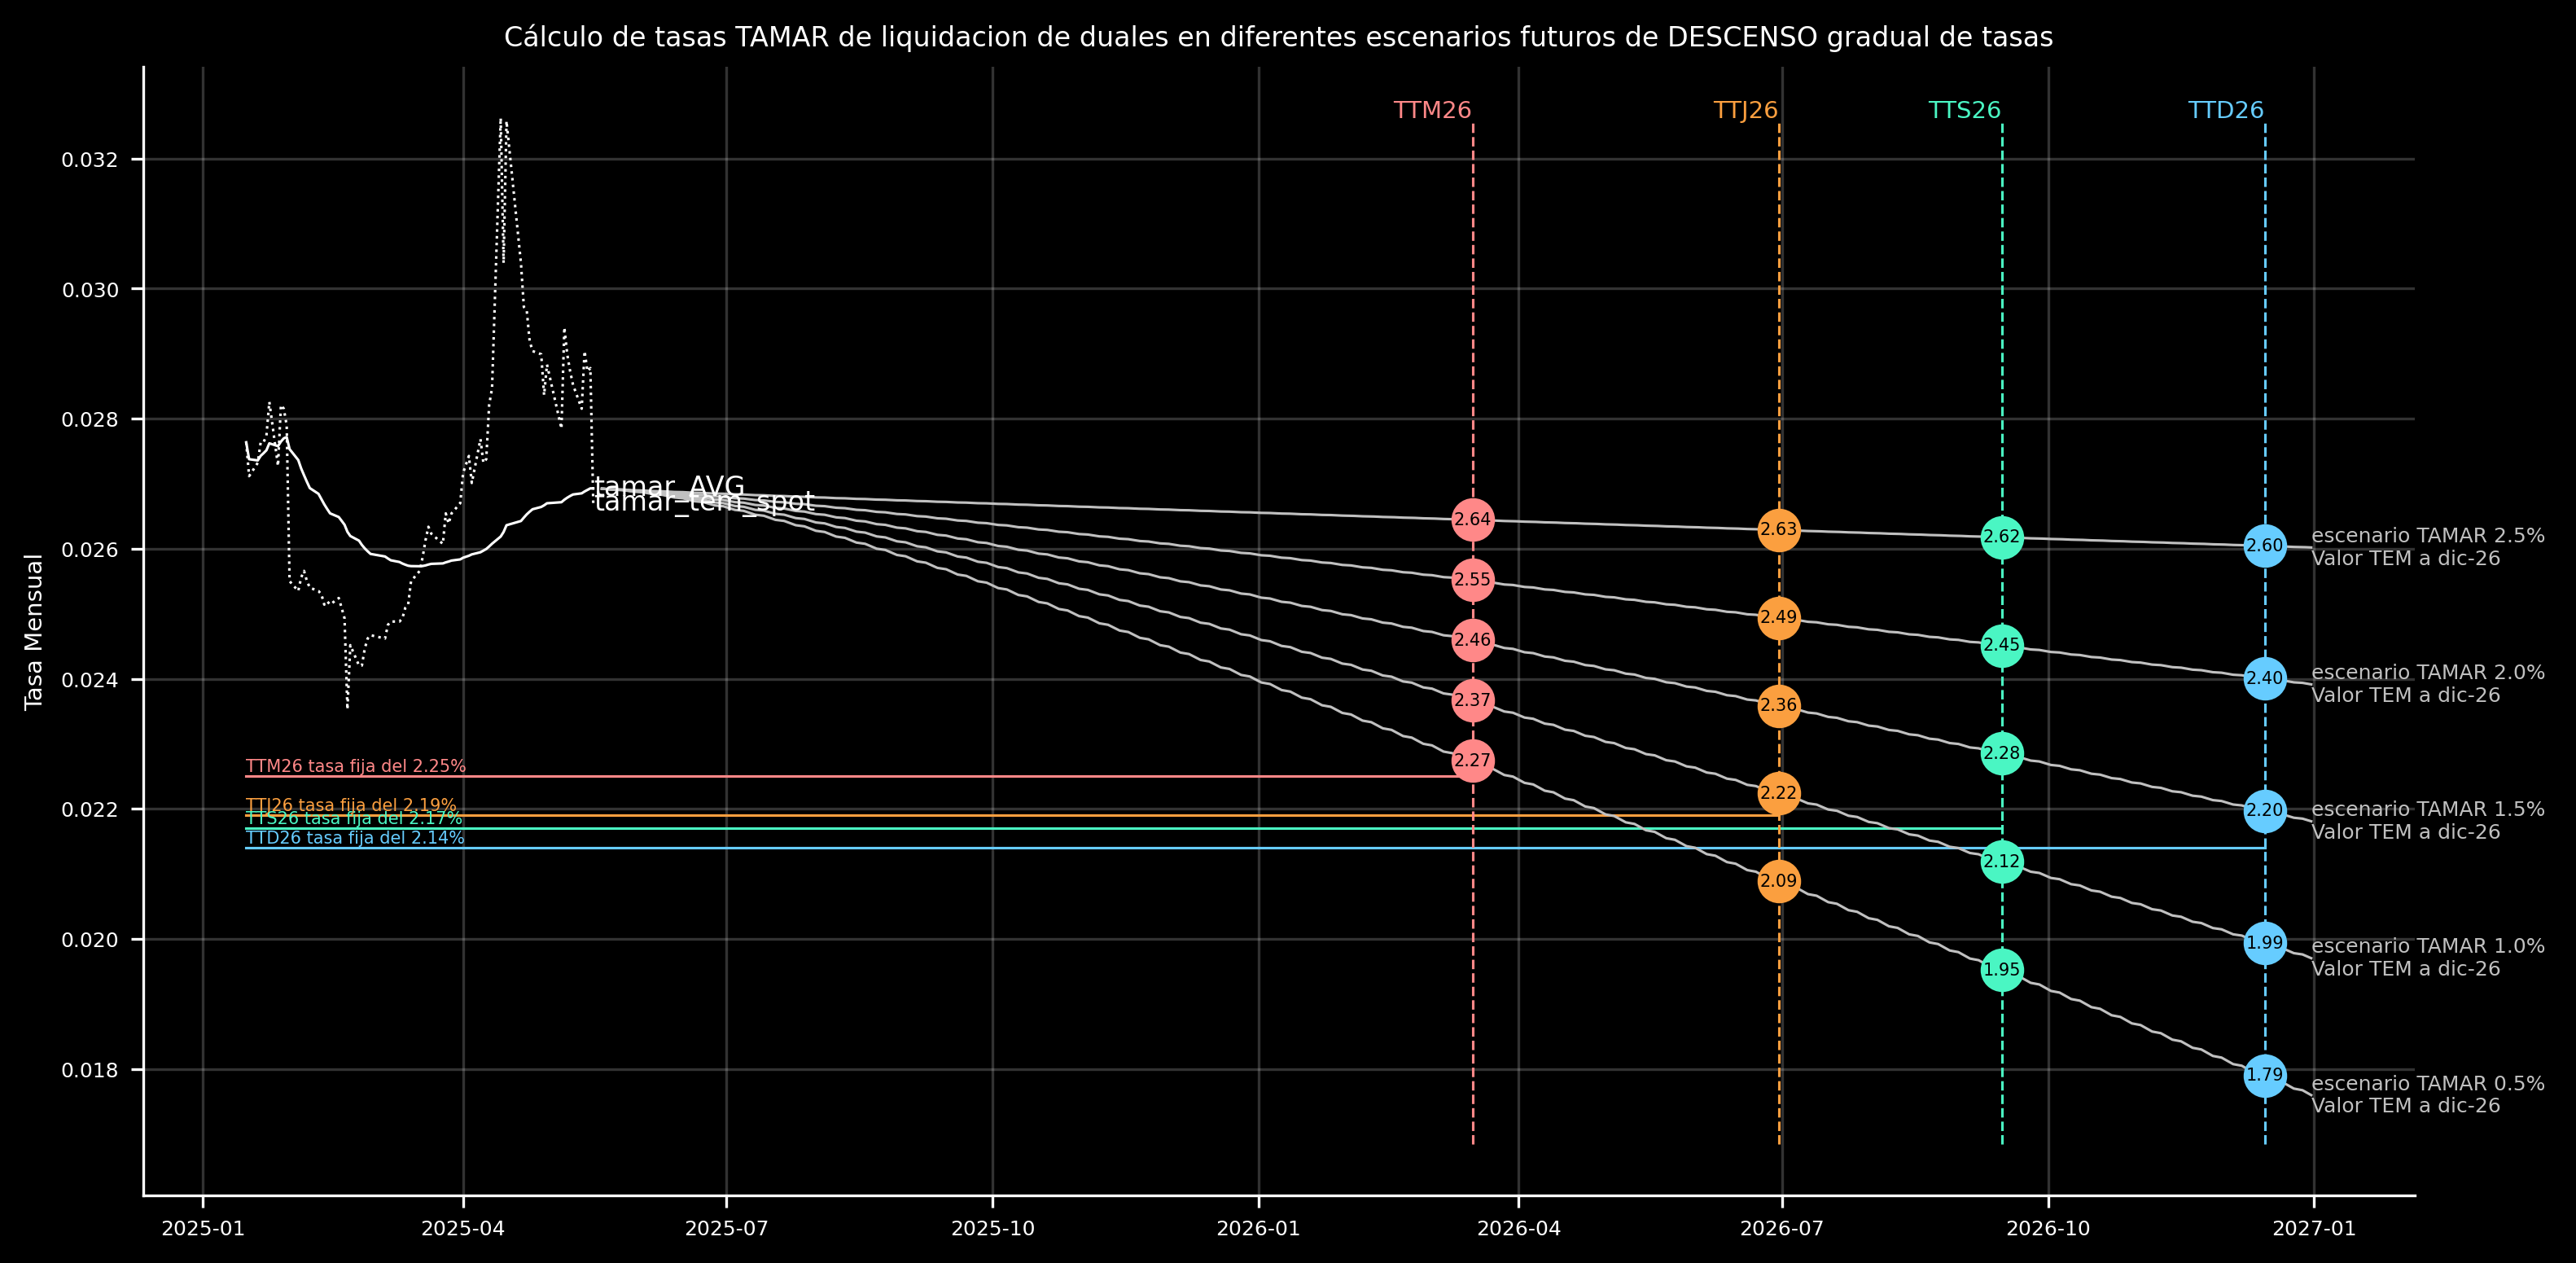

In [ ]:
title_chart = "Cálculo de tasas TAMAR de liquidacion de duales en diferentes escenarios futuros de DESCENSO gradual de tasas"
title_table = "Simulacion de <u>baja de tasas</u>"
TARGETs_TEM = [0.005, 0.01, 0.015, 0.02, 0.025]

df = simulate(TARGETs_TEM)
sobre_tasa_tamar = chart(df, title_chart)
showTables(TARGETs_TEM, sobre_tasa_tamar, title_table)

<br><br>



# Simulacion Suba de tasas

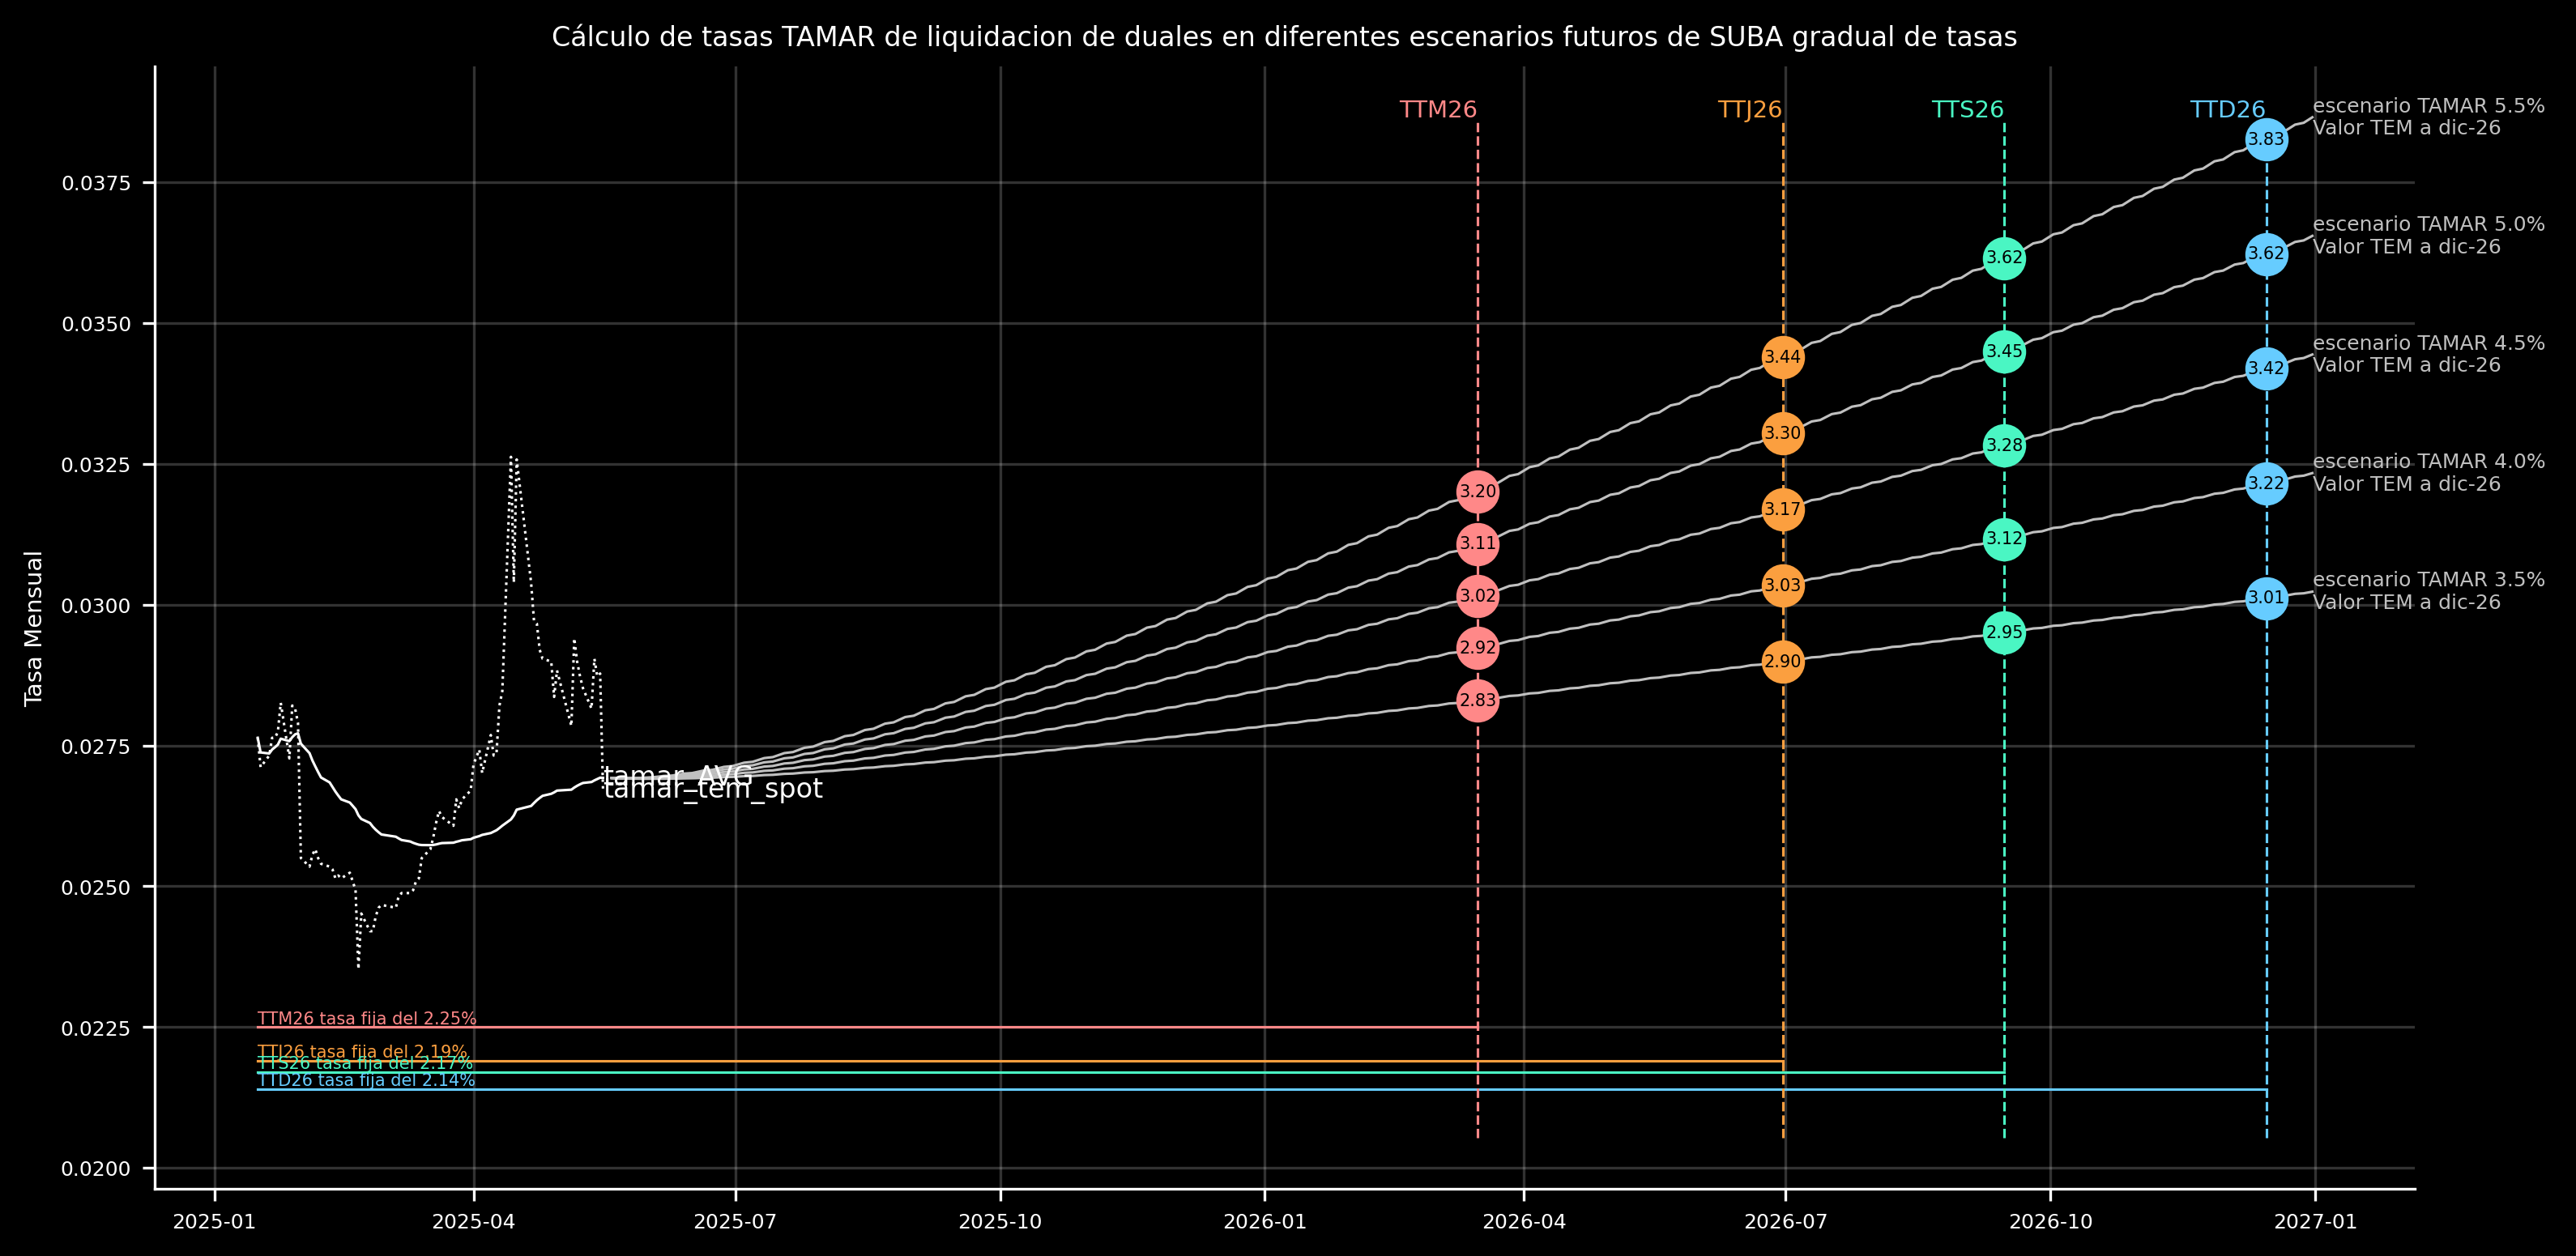

In [ ]:
title_chart = "Cálculo de tasas TAMAR de liquidacion de duales en diferentes escenarios futuros de SUBA gradual de tasas"
title_table = "Simulacion de <u>SUBA de tasas</u>"
TARGETs_TEM = [0.035, 0.04, 0.045, 0.05, 0.055]

df = simulate(TARGETs_TEM)
sobre_tasa_tamar = chart(df, title_chart)
showTables(TARGETs_TEM, sobre_tasa_tamar, title_table)

# Calculo pricing opcionalidad

In [ ]:
tamar_tea = getDataV3(variableID=45)['valor'] / 100   # ID=45 es la TAMAR
tamar_tea.index = pd.to_datetime(tamar_tea.index)
tamar_tea = tamar_tea.sort_index()
tamar_tea = tamar_tea.loc[tamar_tea.index > '2025-01-15']
tamar_tem_spot = ((1 + tamar_tea)**(1/12) - 1)
tamar_tem = tamar_tem_spot.to_frame(name='tamar_tem_spot')

Sea $ X \sim \text{Lognormal}(\mu, \sigma^2) $, con:

$$
X = \exp(Y), \quad \text{donde } Y \sim N(\mu, \sigma^2)
$$

Queremos encontrar parámetros $ \mu $ y $ \sigma $ tales que se cumplan las siguientes condiciones:

1. **Media deseada**: Media REM a dic 26
   $$
   \mathbb{E}[X] = e^{\mu + \frac{1}{2}\sigma^2} = 0.0143
   $$

2. **Probabilidad de cola superior**:  
outlier_prob caso max REM 1/41 (prob: 2.44%  value: 2.71% tem)

   $$
   \mathbb{P}(X > 0.0271) \geq 0.0244
   $$

3. **Dominio efectivo**:
min: riesgo pais 200 bps + FR 400 bps
   
   $$
   X \geq 0.0049
   $$

El problema se formula como una minimización penalizada:

$$
\min_{\mu,\ \sigma > 0} \left( \left( e^{\mu + \frac{1}{2}\sigma^2} - 0.0143 \right)^2 + \lambda \cdot \max\left(0,\ 0.0244 - \mathbb{P}(X > 0.0271) \right)^2 \right)
$$

donde  $\lambda$  pondera la penalización por no cumplir la probabilidad deseada en la cola.


Params de la lognormal: mu: -4.3317, sigma: 0.4613


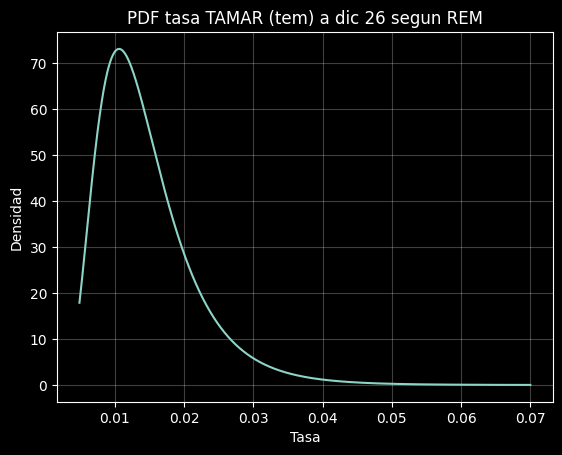

,TAMAR_DIC_26_pct,proba_pct
0,0.7,13.9
1,1.0,23.6
2,1.3,21.6
3,1.7,15.4
4,2.0,9.7
5,2.3,5.8
6,2.7,3.4
7,3.0,2.0
8,3.3,1.2
9,3.7,0.7


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.optimize import minimize

target_mean = 0.0143 # media REM a dic 26
target_prob = 0.0244 # outlier_prob caso max REM 1/41
threshold = 0.0271 # outlier_value REM max a dic26
min_val = 0.0049 # min: riesgo pais 200 bps + FR 400 bps

def loss(params):
    mu, sigma = params
    dist = lognorm(s=sigma, scale=np.exp(mu))
    mean = dist.mean()
    prob = 1 - dist.cdf(threshold)
    penal_mean = (mean - target_mean)**2
    penal_prob = max(0, target_prob - prob)**2
    return penal_mean + 10 * penal_prob

res = minimize(loss, x0=[np.log(target_mean), 0.5], bounds=[(None, None), (1e-3, 2)])

mu_opt, sigma_opt = res.x
dist = lognorm(s=sigma_opt, scale=np.exp(mu_opt))

x = np.linspace(min_val, 0.07, 1000)
pdf = dist.pdf(x)
pdf[x < min_val] = 0

plt.plot(x, pdf)
plt.title('PDF tasa TAMAR (tem) a dic 26 segun REM')
plt.xlabel('Tasa')
plt.ylabel('Densidad')
plt.grid(alpha=0.25)

print(f"Params de la lognormal: mu: {mu_opt:.4f}, sigma: {sigma_opt:.4f}")
plt.show()

# setear N como cantidad de escenarios discretos a modelar, MAX como maximo valor posible de TAMAR a dic26 escenario caos total
N, MAX = 15, 0.055
edges = np.linspace(min_val, MAX, N + 1)
centers = 0.5 * (edges[:-1] + edges[1:])
probs = dist.cdf(edges[1:]) - dist.cdf(edges[:-1])

df = pd.DataFrame({'TAMAR_DIC_26_pct': centers, 'proba_pct': probs}).mul(100).round(1)
display(df)

In [ ]:
TAMAR_MEANS = []
for TAMAR_TARGET in df.TAMAR_DIC_26_pct.tolist():
    tamar_tem1 = tamar_tem.copy()
    tamar_tem1.index=pd.to_datetime(tamar_tem1.index)
    last=tamar_tem1.index.max()
    lv=tamar_tem1.loc[last,'tamar_tem_spot']
    nd=pd.bdate_range(last+pd.Timedelta(1,'D'),'2026-12-15')
    vals=[lv+(TAMAR_TARGET/100-lv)*i/len(nd) for i in range(1,len(nd)+1)]
    tamar_tem2=pd.DataFrame({'tamar_tem_spot':vals},index=nd)
    tamar_tem1=pd.concat([tamar_tem1,tamar_tem2]).sort_index()
    TAMAR_MEANS.append(tamar_tem1.mean().iloc[0]*100)

df['TAMAR_MEAN'] = TAMAR_MEANS

fixed_rate = 2.14
months = 22.53

df['fixed_amort_b100'] = 100 * (1+fixed_rate/100)**months
df['tamar_amort_b100'] = 100 * (1+df['TAMAR_MEAN']/100)**months
df['tamar_diff_b100'] = np.where(df['fixed_amort_b100'] > df['tamar_amort_b100'], 0, df['tamar_amort_b100']-df['fixed_amort_b100'])
df

,TAMAR_DIC_26_pct,proba_pct,TAMAR_MEAN,fixed_amort_b100,tamar_amort_b100,tamar_diff_b100
0,0.7,13.9,1.845108,161.13229,150.970518,0.000000
1,1.0,23.6,1.971280,161.13229,155.240985,0.000000
2,1.3,21.6,2.097451,161.13229,159.626743,0.000000
3,1.7,15.4,2.265679,161.13229,165.658896,4.526606
4,2.0,9.7,2.391850,161.13229,170.325321,9.193031
5,2.3,5.8,2.518021,161.13229,175.117204,13.984913
6,2.7,3.4,2.686249,161.13229,181.707098,20.574808
7,3.0,2.0,2.812420,161.13229,186.804341,25.672051
8,3.3,1.2,2.938591,161.13229,192.038056,30.905766
9,3.7,0.7,3.106819,161.13229,199.234658,38.102368


In [ ]:
call_value_b100 = df['proba_pct'].divide(100) @ df['tamar_diff_b100']
call_value_b100

np.float64(4.714057827485188)